In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from dotenv import load_dotenv
import dask
from dask.distributed import Client, LocalCluster
import dask.distributed

src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path)

from src.utils.constants import *
from src.utils.utils import *
from src.visualization.visualize import *

In [2]:
load_dotenv()
ip = os.getenv("DISTRIBUTED_MAIN_IP")
cluster = LocalCluster()
client = Client(cluster)

In [3]:
ground_truth = pd.read_parquet(GROUND_TRUTH_PATH)
ground_truth = ground_truth[['origin_time', 'label']]

In [4]:
imported_data = {}

for exchange in EXCHANGES:
    imported_data[(CANDLES, exchange)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{exchange}_{CANDLES}_pca_data.parquet'))
    imported_data[(ORDERBOOKS, exchange)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{exchange}_{ORDERBOOKS}_pca_data.parquet'))

In [5]:
merged_df = {}
cols_to_drop = ['origin_time', 'label']

for (data_type, exchange), df in imported_data.items():     
    merged_df[(data_type, exchange)] = {}
    merged_df[(data_type, exchange)]['full'] = pd.merge(ground_truth[cols_to_drop], df, on='origin_time', how='inner')
    merged_df[(data_type, exchange)]['X'] = merged_df[(data_type, exchange)]['full'].drop(cols_to_drop, axis=1)
    merged_df[(data_type, exchange)]['y'] = merged_df[(data_type, exchange)]['full']['label']

In [6]:
# @dask.delayed
def process_dataset(data_type, exchange, param_distributions, df):
    X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Nested Cross-Validation: Uses an outer loop for model evaluation and an inner loop for hyperparameter tuning.
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    
    # Initialize the base classifier
    clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
    
    # Initialize the RandomizedSearchCV object
    randomized_search = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, n_iter=50, cv=inner_cv, scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)

    # Perform nested cross-validation
    nested_scores = cross_val_score(randomized_search, df['X'], df['y'], cv=outer_cv, scoring='accuracy')
    
    # Fit the random search to the training data
    randomized_search.fit(X_train, y_train)

    # Best parameters and score from RandomizedSearchCV
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_
    best_clf = randomized_search.best_estimator_

    # Predict on the test set using the best estimator
    y_pred = best_clf.predict(X_test)

    # Evaluate the model
    evaluation = get_evaluation(y_test, y_pred)

    # Collect learning curve data
    train_scores = []
    test_scores = []
    depths = param_distributions['max_depth']

    # Gather learning curve data
    for depth in depths:
        model = DecisionTreeClassifier(
            criterion=best_params['criterion'],
            random_state=RANDOM_STATE, 
            max_depth=depth,
            min_samples_split=best_params['min_samples_split'], 
            min_samples_leaf=best_params['min_samples_leaf'],
            max_leaf_nodes=best_params.get('max_leaf_nodes', None),
            min_impurity_decrease=best_params.get('min_impurity_decrease', 0.0)
        )
        
        # Cross-validation on the training data
        train_cv_results = cross_val_score(model, X_train, y_train, cv=inner_cv, scoring='accuracy')
        train_scores.append(train_cv_results.mean())
        
        # Evaluate on the test set
        model.fit(X_train, y_train)
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)

    return {
        'best_params': best_params,
        'best_score': best_score,
        'nested_scores': nested_scores,
        'evaluation': evaluation,
        'train_scores': train_scores,
        'test_scores': test_scores,
        'depths': depths
    }

In [7]:
param_distributions = {
    'criterion': [PARAM_DISTRIBUTION_CRITERION],
    'max_depth': range(1, 20),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [10, 20, 30, 50],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1]
}

In [8]:
# tasks = [process_dataset(data_type, exchange, param_distributions, df) for (data_type, exchange), df in data.items()]
# futures = client.compute(tasks)
# results = client.gather(futures)

In [9]:
# for (data_type, exchange), result in zip(data.keys(), results):
#     print(f"Best parameters for {exchange} {data_type}: {result['best_params']}")
#     print(f'{exchange} {data_type} Nested CV Accuracy: {result["nested_scores"].mean():.2f}')
#     print(f'{exchange} {data_type} Test Set Accuracy: {result["evaluation"]["accuracy"]:.2f}')
#     print(f'{exchange} {data_type} Classification Report:')
#     display(result['evaluation']['classification_report'])
#     print(f'{exchange} {data_type} Confusion Matrix:')
#     display(result['evaluation']['confusion_matrix'])

#     plot_tree_learning_curves(exchange, data_type, result['depths'], result['train_scores'], result['test_scores'], 'decision_tree')

#     pd.DataFrame.to_pickle(result, os.path.join(PROCESSED_DATA_PATH, f'{exchange}_{data_type}_decision_tree_results.pkl'))

Results for BINANCE candles:
Best parameters: {'min_samples_split': 50, 'min_samples_leaf': 50, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_depth': 17, 'criterion': 'entropy', 'ccp_alpha': 0.0}
Nested CV Accuracy: 0.70
Accuracy: 0.70
Classification Report:


,precision,recall,f1-score,support
positive,0.396507,0.080829,0.134283,24719.000000
neutral,0.709097,0.984944,0.824562,108395.000000
negative,0.451722,0.037926,0.069976,24548.000000
accuracy,0.695742,0.695742,0.695742,0.695742
macro avg,0.519109,0.367899,0.342940,157662.000000
weighted avg,0.620014,0.695742,0.598847,157662.000000


Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,1998,22050,671
true:neutral,1173,106763,459
true:negative,1868,21749,931


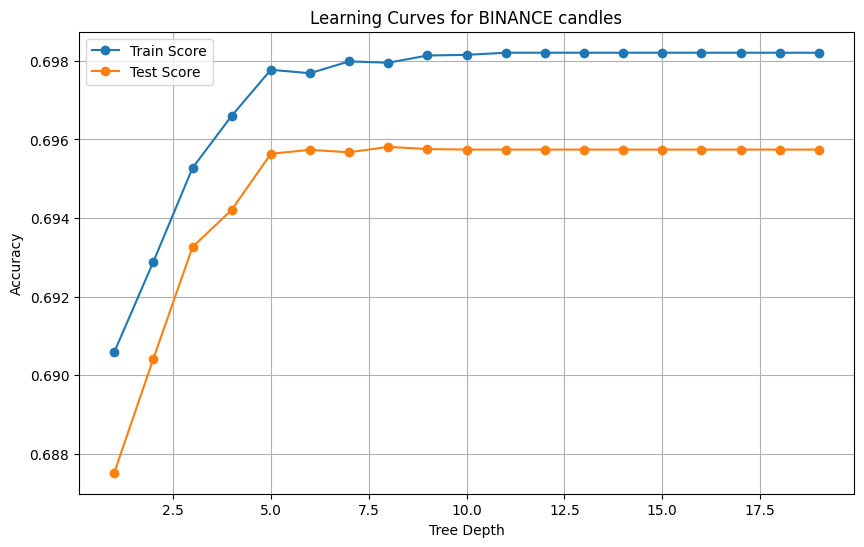

Results for BINANCE orderbooks:
Best parameters: {'min_samples_split': 50, 'min_samples_leaf': 50, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_depth': 17, 'criterion': 'entropy', 'ccp_alpha': 0.0}
Nested CV Accuracy: 0.69
Accuracy: 0.69
Classification Report:


,precision,recall,f1-score,support
positive,0.322581,0.002262,0.004492,22109.000000
neutral,0.693010,0.999208,0.818407,99693.000000
negative,0.294737,0.001262,0.002513,22189.000000
accuracy,0.692349,0.692349,0.692349,0.692349
macro avg,0.436776,0.334244,0.275137,143991.000000
weighted avg,0.574759,0.692349,0.567705,143991.000000


Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,50,22028,31
true:neutral,43,99614,36
true:negative,62,22099,28


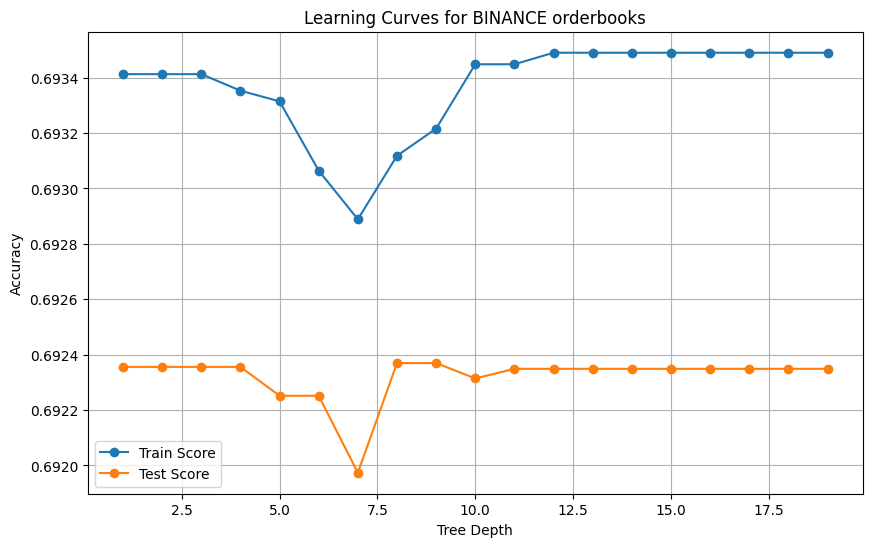

Results for HUOBI candles:
Best parameters: {'min_samples_split': 50, 'min_samples_leaf': 30, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_depth': 14, 'criterion': 'entropy', 'ccp_alpha': 0.0}
Nested CV Accuracy: 0.70
Accuracy: 0.70
Classification Report:


,precision,recall,f1-score,support
positive,0.395437,0.022740,0.043006,18294.000000
neutral,0.711479,0.989474,0.827759,84931.000000
negative,0.400802,0.054236,0.095543,18438.000000
accuracy,0.702375,0.702375,0.702375,0.702375
macro avg,0.502572,0.355483,0.322103,121663.000000
weighted avg,0.616874,0.702375,0.598792,121663.000000


Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,416,16990,888
true:neutral,287,84037,607
true:negative,349,17089,1000


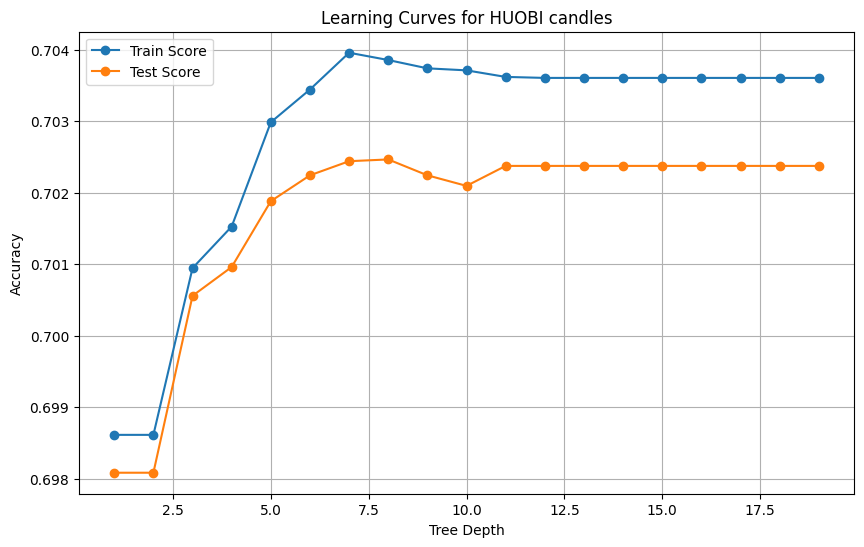

/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Results for HUOBI orderbooks:
Best parameters: {'min_samples_split': 50, 'min_samples_leaf': 20, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': 100, 'max_depth': 17, 'criterion': 'entropy', 'ccp_alpha': 0.1}
Nested CV Accuracy: 0.69
Accuracy: 0.69
Classification Report:


,precision,recall,f1-score,support
positive,0.000000,0.000000,0.000000,18133.00000
neutral,0.690290,1.000000,0.816771,81410.00000
negative,0.000000,0.000000,0.000000,18393.00000
accuracy,0.690290,0.690290,0.690290,0.69029
macro avg,0.230097,0.333333,0.272257,117936.00000
weighted avg,0.476500,0.690290,0.563808,117936.00000


Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,0,18133,0
true:neutral,0,81410,0
true:negative,0,18393,0


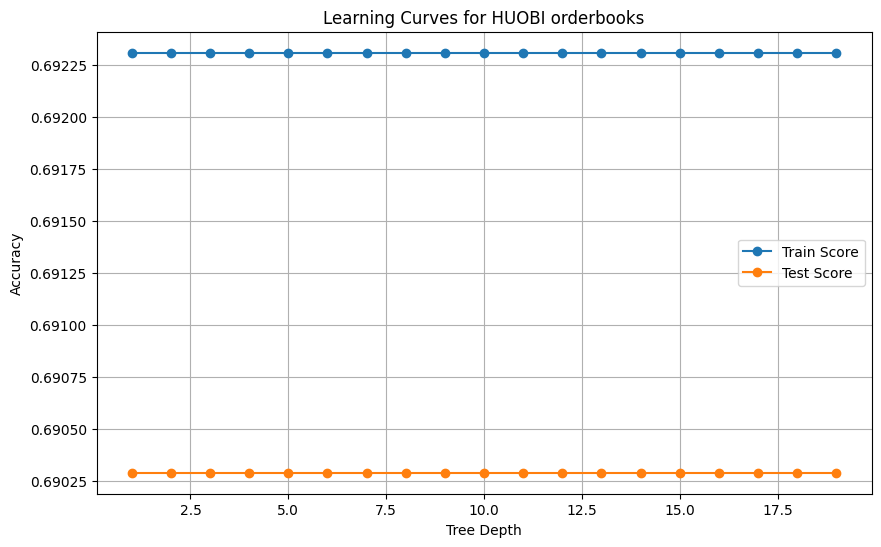

Results for OKX candles:
Best parameters: {'min_samples_split': 50, 'min_samples_leaf': 50, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_depth': 17, 'criterion': 'entropy', 'ccp_alpha': 0.0}
Nested CV Accuracy: 0.71
Accuracy: 0.71
Classification Report:


,precision,recall,f1-score,support
positive,0.384898,0.068809,0.116747,18297.000000
neutral,0.723683,0.979132,0.832247,85012.000000
negative,0.416889,0.076647,0.129486,18357.000000
accuracy,0.706064,0.706064,0.706064,0.706064
macro avg,0.508490,0.374863,0.359493,121666.000000
weighted avg,0.626445,0.706064,0.618612,121666.000000


Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,1259,15947,1091
true:neutral,897,83238,877
true:negative,1115,15835,1407


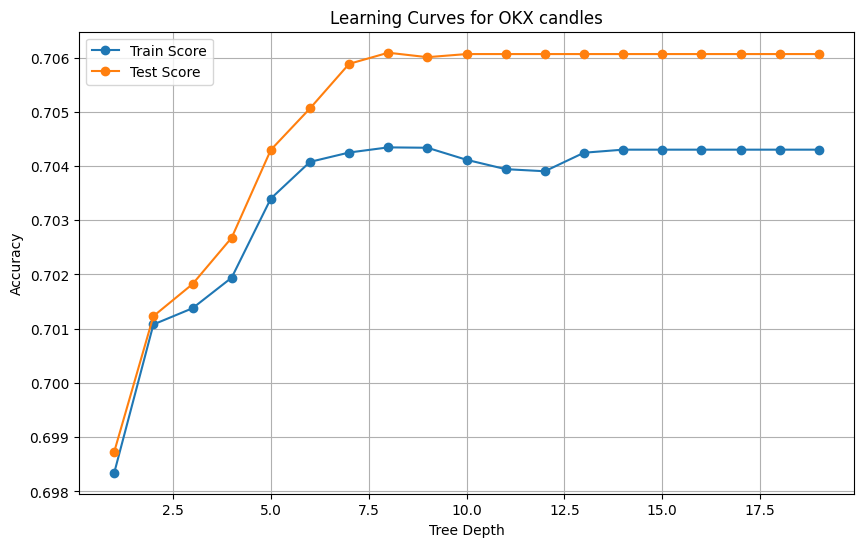

/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francescoperagine/Documents/Repository/big_data_bitcoin_forecasting/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Results for OKX orderbooks:
Best parameters: {'min_samples_split': 50, 'min_samples_leaf': 20, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': 100, 'max_depth': 17, 'criterion': 'entropy', 'ccp_alpha': 0.1}
Nested CV Accuracy: 0.69
Accuracy: 0.69
Classification Report:


,precision,recall,f1-score,support
positive,0.000000,0.000000,0.000000,18133.00000
neutral,0.690290,1.000000,0.816771,81410.00000
negative,0.000000,0.000000,0.000000,18393.00000
accuracy,0.690290,0.690290,0.690290,0.69029
macro avg,0.230097,0.333333,0.272257,117936.00000
weighted avg,0.476500,0.690290,0.563808,117936.00000


Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,0,18133,0
true:neutral,0,81410,0
true:negative,0,18393,0


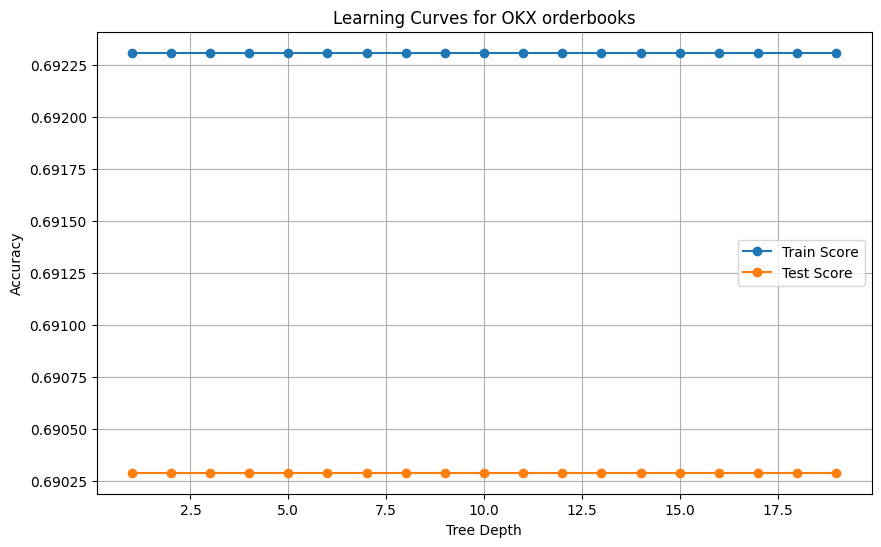

In [11]:
for (data_type, exchange), df in merged_df.items():
    result = process_dataset(data_type, exchange, param_distributions, df)
    print(f"Results for {exchange} {data_type}:")
    print(f"Best parameters: {result['best_params']}")
    print(f'Nested CV Accuracy: {result["nested_scores"].mean():.2f}')
    print(f'Accuracy: {result["evaluation"]["accuracy"]:.2f}')
    print(f'Classification Report:')
    display(result['evaluation']['classification_report'])
    print(f'Confusion Matrix:')
    display(result['evaluation']['confusion_matrix'])
    plot_tree_learning_curves(exchange, data_type, result['depths'], result['train_scores'], result['test_scores'], 'decision_tree')
    pd.DataFrame.to_pickle(result, os.path.join(PROCESSED_DATA_PATH, f'{exchange}_{data_type}_decision_tree_results.pkl'))